## Reading Libraries and dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

In [2]:
train = pd.HDFStore('train_data.h5')
y_train = train['labels']
X_train = train['rpkm']
idx1 = y_train.index
X_train= X_train.loc[idx1, :]

In [3]:
test = pd.HDFStore('test_data.h5')
y_test = test['labels']
X_test = test['rpkm']

## PART 3: Feature selection before PCA

### Biological variance

In [37]:
genes = X_train.columns
genes_df = pd.DataFrame(index=genes)
genes_df['mean'] = X_train.mean()
genes_df['std'] = X_train.std()
genes_df['variance'] = genes_df['std']**2
##biological variance = Total variance - the observed mean expression
genes_df['bio_var'] = genes_df['variance'] - genes_df['mean']

In [38]:
genes_df = genes_df.sort_values(by=['bio_var'], ascending=False)

In [39]:
from sklearn.svm import SVC
no_genes = [2000, 3000, 5000, 7000, 10000]
accuracies_pca_test = []
accuracies_pca_train = []
for i in no_genes:
    print(i)
    genes = genes_df.iloc[:i, :].index
    X_train_new = X_train.loc[:, genes]
    X_test_new = X_test.loc[:, genes]
    pca = PCA(n_components=200)
    X_train_pca = pca.fit_transform(X_train_new)
    X_test_pca = pca.transform(X_test_new)
    model = SVC()
    model.fit(X_train_pca[:, :120], y_train)
    y_pred = model.predict(X_test_pca[:, :120])
    y_pred_train = model.predict(X_train_pca[:, :120])
    accuracy = accuracy_score(y_test, y_pred)
    train_accuracy = accuracy_score(y_train, y_pred_train)
    accuracies_pca_test.append(accuracy)
    accuracies_pca_train.append(train_accuracy)

2000
3000
5000
7000
10000


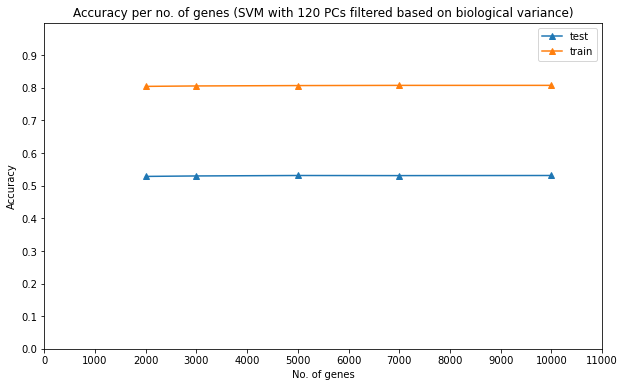

In [40]:
plt.figure(figsize=(10,6))
plt.plot(no_genes, accuracies_pca_test, label='test', marker = '^')
plt.plot(no_genes, accuracies_pca_train, label='train',  marker = '^')
plt.ylabel('Accuracy')
plt.xlabel('No. of genes')
plt.title('Accuracy per no. of genes (SVM with 120 PCs filtered based on biological variance)')
plt.xlim([0, 10000])
plt.ylim([0, 1])
plt.xticks(np.arange(0, 12000, 1000))
plt.yticks(np.arange(0,1, 0.1))
plt.legend()
plt.savefig('pca_svm_biovar.png', dpi=300)

In [41]:
accuracies_pca_test

[0.5285464098073556,
 0.5299474605954466,
 0.5313485113835377,
 0.5309982486865149,
 0.5313485113835377]

In [47]:
accuracies_pca_train

[0.8045724437795129,
 0.8058815278881668,
 0.8070503529851792,
 0.8076581420356258,
 0.8077048950395063]

### Trying different PCs using 5000 genes

In [42]:
genes = genes_df.iloc[:5000, :].index
X_train_5000 = X_train.loc[:, genes]
X_test_5000 = X_test.loc[:, genes]
pca = PCA(n_components=200)
X_train_pca_5000 = pca.fit_transform(X_train_5000)
X_test_pca_5000 = pca.transform(X_test_5000)

In [43]:
from sklearn.svm import SVC
no_pcs = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200]
accuracies_pca_test_5000 = []
accuracies_pca_train_5000 = []

for i in no_pcs:
    clf =  SVC()
    clf.fit(X_train_pca_5000[:, :i], y_train)
    y_pred = clf.predict(X_test_pca_5000[:, :i])
    y_pred_train = clf.predict(X_train_pca_5000[:, :i])
    accuracy = accuracy_score(y_test, y_pred)
    train_accuracy = accuracy_score(y_train, y_pred_train)
    accuracies_pca_test_5000.append(accuracy)
    accuracies_pca_train_5000.append(train_accuracy)

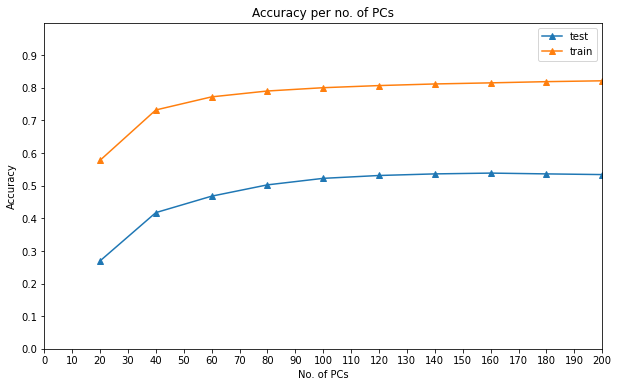

In [44]:
plt.figure(figsize=(10,6))
plt.plot(no_pcs, accuracies_pca_test_5000, label='test', marker = '^')
plt.plot(no_pcs, accuracies_pca_train_5000, label='train', marker = '^')
plt.ylabel('Accuracy')
plt.xlabel('No. of PCs')
plt.title('Accuracy per no. of PCs')
plt.xlim([0, 200])
plt.ylim([0, 1])
plt.xticks(np.arange(0, 210, 10))
plt.yticks(np.arange(0,1, 0.1))
plt.legend()
plt.savefig('pca_svm_biovar_5000.png', dpi=300)

In [45]:
accuracies_pca_test_5000

[0.2693520140105079,
 0.41751313485113833,
 0.4679509632224168,
 0.5026269702276708,
 0.5225919439579685,
 0.5313485113835377,
 0.5362521891418564,
 0.5387040280210158,
 0.5362521891418564,
 0.5341506129597198]

In [48]:
accuracies_pca_train_5000

[0.5778203749590911,
 0.7322455467763804,
 0.7724063771097293,
 0.7904062836037216,
 0.8005049324419093,
 0.8070503529851792,
 0.8120061713965122,
 0.8153723876759081,
 0.8190658749824676,
 0.8216840431997756]

### Silhouette-Score Filter 

In [16]:
feature_scores = pd.read_csv('feature_silhouette_scores.txt', index_col= 'Unnamed: 0')

In [27]:
feature_scores

,silhouette_score
100009600,-0.757809
100009609,-0.815316
100009614,-0.417372
100012,-0.844808
100017,-0.848211
...,...
99887,-0.776735
99889,-0.744287
99890,-0.880555
99899,-0.817491


In [17]:
percentages = range(10,60,10)
score_splits = -np.nanpercentile(-feature_scores, percentages, axis=0)

In [32]:
train_accuracies = []
test_accuracies = []

for i in range(len(score_splits)):
    print(score_splits[i])

    feat_col = feature_scores[feature_scores['silhouette_score'] > score_splits[i][0]].index
    X_train_feat = X_train.loc[:, feat_col]
    X_test_feat = X_test.loc[:, feat_col]
    
    #print(X_train_feat.shape)
    pca = PCA(n_components=200)
    X_train_pca_ss = pca.fit_transform(X_train_feat)
    X_test_pca_ss= pca.transform(X_test_feat)
    model = SVC()
    model.fit(X_train_pca_ss[:, :120], y_train)
    y_pred = model.predict(X_test_pca_ss[:, :120])
    y_pred_train = model.predict(X_train_pca_ss[:, :120])
    accuracy = accuracy_score(y_test, y_pred)
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracies.append(accuracy)
    train_accuracies.append(train_accuracy)

[-0.55076491]
[-0.61019145]
[-0.65833897]
[-0.70698023]
[-0.75138253]


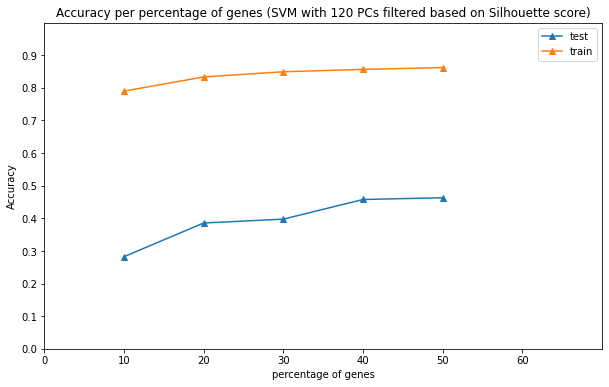

In [46]:
plt.figure(figsize=(10,6))
plt.plot(percentages, test_accuracies, label='test', marker = '^')
plt.plot(percentages,train_accuracies, label='train',  marker = '^')
plt.ylabel('Accuracy')
plt.xlabel('percentage of genes')
plt.title('Accuracy per percentage of genes (SVM with 120 PCs filtered based on Silhouette score)')
plt.xlim([0, 70])
plt.ylim([0, 1])
plt.xticks(np.arange(0, 70, 10))
plt.yticks(np.arange(0,1, 0.1))
plt.legend()
plt.savefig('pca_svm_ss.png', dpi=300)

In [36]:
test_accuracies

[0.28231173380035024,
 0.3856392294220666,
 0.3975481611208406,
 0.45779334500875657,
 0.46304728546409807]

In [49]:
train_accuracies

[0.7899855065687971,
 0.8334658001776614,
 0.8493618214970312,
 0.856655290102389,
 0.8623124035719295]